<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project - Zoom Ally: A Running Form Classifier (Overstriding)

> Authors: Lee Hongwei
---

**Problem Statement:**
Our challenge is to devise a solution that empowers individuals to **detect one of the most prevalent running form anomalies: overstriding.**

There are a total of ___ notebooks for this project:  
 1. `01_Data_Collection_Video_Dl.ipynb`   
 2. `02_Data_Collection_Pose_Estimation.ipynb`   
 3. `03_Data_Preprocessing_and_Modelling.ipynb`
 4. `04_`

---
**This Notebook**
- Ensure that all numpy arrays are of the same shape for modelling
- Training classification models

# 1. Install and Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers import TimeDistributed
from keras.models import load_model

# 2. Data Processing

## 2.1 Renaming .npy files chronologically

Some frames were skipped during the data collection process due to processing issues. This could likely happen during a real use case thus some processing will be required to make sure that the extracted numpy arrays are organised before it is further processed.

For e.g. if frame 5 was skipped by the pose estimation model, the numpy array for frame 5 would not be saved leading to a missing file.

In [2]:
# Define a function to rename npy files chronologically

def rename_npy_files(data_directory):
    # Loop through each folder in the directory
    for folder_name in os.listdir(data_directory):
        folder_path = os.path.join(data_directory, folder_name)
        if os.path.isdir(folder_path):
            # Get a list of .npy files in the folder
            npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]

            # Custom sorting function to sort numerically
            def numerical_sort(file_name):
                parts = file_name.split('.')
                try:
                    return int(parts[0]) if parts[0].isdigit() else file_name  # Check if the first part is a number
                except ValueError:
                    return file_name  # Return the file name as is if not a number

            npy_files.sort(key=numerical_sort)  # Sort the .npy files numerically

            # Generate new sorted names for the .npy files
            new_names = [f"{i}.npy" for i in range(len(npy_files))]

            # Rename the .npy files using the new sorted names
            for old_name, new_name in zip(npy_files, new_names):
                old_path = os.path.join(folder_path, old_name)
                new_path = os.path.join(folder_path, new_name)
                os.rename(old_path, new_path)

            # Print folder name and number of .npy files renamed
            print(f"Renamed {len(npy_files)} .npy files in folder {folder_name}")

In [3]:
data_directory = '../datasets/no_overstride_npy'
rename_npy_files(data_directory)

Renamed 258 .npy files in folder F_Running_4_flipped
Renamed 258 .npy files in folder M_Running_2_flipped
Renamed 258 .npy files in folder M_Running_3_flipped
Renamed 258 .npy files in folder F_Running_5_flipped
Renamed 258 .npy files in folder M_Running_1_flipped
Renamed 258 .npy files in folder F_Running_6
Renamed 258 .npy files in folder F_Running_8
Renamed 258 .npy files in folder M_Running_8_flipped
Renamed 258 .npy files in folder F_Running_7_flipped
Renamed 258 .npy files in folder F_Running_7
Renamed 258 .npy files in folder M_Running_7
Renamed 258 .npy files in folder F_Running_6_flipped
Renamed 258 .npy files in folder M_Running_1
Renamed 258 .npy files in folder M_Running_6
Renamed 258 .npy files in folder M_Running_8
Renamed 258 .npy files in folder M_Running_5_flipped
Renamed 258 .npy files in folder F_Running_3_flipped
Renamed 258 .npy files in folder F_Running_2_flipped
Renamed 258 .npy files in folder M_Running_4_flipped
Renamed 258 .npy files in folder F_Running_2
Rena

In [4]:
data_directory = '../datasets/overstride_npy'
rename_npy_files(data_directory)

Renamed 258 .npy files in folder Overstride_9_flipped
Renamed 258 .npy files in folder Overstride_10_flipped
Renamed 258 .npy files in folder Overstride_8_flipped
Renamed 258 .npy files in folder Overstride_11_flipped
Renamed 258 .npy files in folder Overstride_13_flipped
Renamed 258 .npy files in folder Overstride_14
Renamed 258 .npy files in folder Overstride_13
Renamed 258 .npy files in folder Overstride_3_flipped
Renamed 258 .npy files in folder Overstride_12
Renamed 258 .npy files in folder Overstride_15
Renamed 258 .npy files in folder Overstride_5
Renamed 258 .npy files in folder Overstride_2_flipped
Renamed 258 .npy files in folder Overstride_2
Renamed 258 .npy files in folder Overstride_12_flipped
Renamed 258 .npy files in folder Overstride_3
Renamed 258 .npy files in folder Overstride_4
Renamed 258 .npy files in folder Overstride_17_flipped
Renamed 258 .npy files in folder Overstride_7_flipped
Renamed 258 .npy files in folder Overstride_6_flipped
Renamed 258 .npy files in fol

## 2.1 Data Duplication for Frame Uniformity

Since each video has very different number of frames (min=57, max=366), I will need to make sure that the number of frames are uniform for the model to read. Below are the ways this can be done and a conclusion on why duplication is my chosen methodology:

**Method 1**
Zero-padding: 
- Fills in 'empty' frames with zeros such that the shape of each numpy array fits the longest video's numpy array. 
- For cyclical movements like running, where each frame contributes to understanding the overall stride pattern, zero-padding might not be ideal as it adds artificial data that doesn't reflect the movement dynamics.

**Method 2**
Data Duplication: 
- Duplicating frames can be useful for maintaining temporal continuity without introducing artificial data
- In running analysis, duplicating frames can help in preserving the cyclical nature of the movement, ensuring that each phase of the stride cycle is adequately represented.

**Method 3** 
Interpolating Frames: 
- Interpolation techniques can generate intermediate frames based on existing frames, maintaining the temporal structure while filling gaps.
- This approach can be beneficial for capturing smooth transitions in running movements, especially when the frame rate is variable.

**CONCLUSION** <br> 
Ultimately, I've decided to go with Data Duplication, since the nature of a runners' movement is cyclical and it does not create artificial data.

Interpolation could be an interesting way to pre-process the data, especially if some datapoints have been missed. This could be used to impute missing data instead of how we processed our data in the above section (essentially dropping missing frames). However through some research, we have found out that the methods of interpolation could create artificial data that is impossible for a body's form to be in, and requires heavier computation which will affect the eventual implementation's performance.

### 2.1.1 Checking files for no_overstride data

In [5]:
# Define the path to your data directory
DATA_PATH = '../datasets/no_overstride_npy'

# Get a list of all folders (videos) in the data directory
video_folders_g = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]

In [6]:
video_folders_g

['F_Running_4_flipped',
 'M_Running_2_flipped',
 'M_Running_3_flipped',
 'F_Running_5_flipped',
 'M_Running_1_flipped',
 'F_Running_6',
 'F_Running_8',
 'M_Running_8_flipped',
 'F_Running_7_flipped',
 'F_Running_7',
 'M_Running_7',
 'F_Running_6_flipped',
 'M_Running_1',
 'M_Running_6',
 'M_Running_8',
 'M_Running_5_flipped',
 'F_Running_3_flipped',
 'F_Running_2_flipped',
 'M_Running_4_flipped',
 'F_Running_2',
 'F_Running_5',
 'F_Running_4',
 'F_Running_3',
 'M_Running_6_flipped',
 'F_Running_8_flipped',
 'M_Running_7_flipped',
 'M_Running_3',
 'M_Running_4',
 'M_Running_5',
 'M_Running_2']

In [7]:
# Find folder amongst good running videos for longest video

max_frames_no = 0  # Max frames of no_overstride videos
max_folder = ''
for folder_name in video_folders_g:
    folder_path = os.path.join(DATA_PATH, folder_name)
    npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    num_frames = len(npy_files)
    if num_frames > max_frames_no:
        max_frames_no = num_frames
        max_folder = folder_path


In [8]:
max_frames_no, max_folder

(258, '../datasets/no_overstride_npy/F_Running_4_flipped')

### 2.1.2 Checking files for overstride data

In [9]:
# Define the path to your data directory
DATA_PATH = '../datasets/overstride_npy'

# Get a list of all folders (videos) in the data directory
video_folders_b = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]

In [10]:
video_folders_b

['Overstride_9_flipped',
 'Overstride_10_flipped',
 'Overstride_8_flipped',
 'Overstride_11_flipped',
 'Overstride_13_flipped',
 'Overstride_14',
 'Overstride_13',
 'Overstride_3_flipped',
 'Overstride_12',
 'Overstride_15',
 'Overstride_5',
 'Overstride_2_flipped',
 'Overstride_2',
 'Overstride_12_flipped',
 'Overstride_3',
 'Overstride_4',
 'Overstride_17_flipped',
 'Overstride_7_flipped',
 'Overstride_6_flipped',
 'Overstride_16_flipped',
 'Overstride_4_flipped',
 'Overstride_10',
 'Overstride_17',
 'Overstride_16',
 'Overstride_11',
 'Overstride_14_flipped',
 'Overstride_6',
 'Overstride_15_flipped',
 'Overstride_8',
 'Overstride_9',
 'Overstride_7',
 'Overstride_5_flipped']

In [11]:
# Find the folder amongst overstride videos for longest video

max_frames_o = 0  # Max frames of no_overstride videos
max_folder = ''
for folder_name in video_folders_b:
    folder_path = os.path.join(DATA_PATH, folder_name)
    npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    num_frames = len(npy_files)
    if num_frames > max_frames_o:
        max_frames_o = num_frames
        max_folder = folder_path


In [12]:
max_frames_o, max_folder

(258, '../datasets/overstride_npy/Overstride_9_flipped')

In [13]:
max_frames = max(max_frames_o, max_frames_no)
print(f'longest video has {max_frames} frames')

longest video has 258 frames


## 2.2 Duplicate frames to fill missing data from shorter videos

### 2.2.1 Define a function to duplicate frames

In [14]:
def duplicate_frames(video_folders, max_frames):
    # Loop through each video folder again to duplicate data if needed
    for folder_name in video_folders:
        folder_path = os.path.join(DATA_PATH, folder_name)
        npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
        num_files = len(npy_files)
        
        # Calculate the number of duplicates needed to match the max frame count
        num_duplicates = max_frames - num_files
        
        # Duplicate the frames sequentially to fill up the required duplicates
        if num_duplicates > 0:
            # Get the last index present in the folder
            last_index = max([int(f.split('.')[0]) for f in npy_files]) if npy_files else -1

            for i in range(num_duplicates):
                src_file_index = (last_index + i + 1) % num_files  # Calculate source index
                src_file_path = os.path.join(folder_path, f'{src_file_index}.npy')  # Adjust file name
                dst_file_path = os.path.join(folder_path, f'{last_index + i + 1}.npy')  # Adjust destination file name
                frame_data = np.load(src_file_path)  # Copy from source file
                np.save(dst_file_path, frame_data)  # Paste to new file

    print("Data duplication completed.")

### 2.2.2 Duplicate frames from the overstride folder

In [15]:
# duplicate frames for overstride
# Define the path to your data directory
DATA_PATH = '../datasets/overstride_npy'

# Get a list of all folders (videos) in the data directory
video_folders = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]

duplicate_frames(video_folders, max_frames)

Data duplication completed.


### 2.2.3 Duplicate frames from the no_overstride folder

In [16]:
# duplicate frames for no_overstride
# Define the path to your data directory
DATA_PATH = '../datasets/no_overstride_npy'

# Get a list of all folders (videos) in the data directory
video_folders = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]

duplicate_frames(video_folders, max_frames)

Data duplication completed.


In [17]:
# Check that all my .npy folders have the same number of frames

def count_npy_files_in_folders(directory):
    folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    npy_counts = {}

    for folder in folders:
        folder_path = os.path.join(directory, folder)
        npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
        npy_counts[folder] = len(npy_files)

    return npy_counts

In [18]:
# no_overstride

directory_path = '../datasets/no_overstride_npy'

npy_counts = count_npy_files_in_folders(directory_path)

# Get the unique counts of all values
unique_counts = len(set(npy_counts.values()))

# Print the unique counts of all values
print("Unique counts of all values:", unique_counts)

Unique counts of all values: 1


In [19]:
# overstride

directory_path = '../datasets/overstride_npy'

npy_counts = count_npy_files_in_folders(directory_path)

# Get the unique counts of all values
unique_counts = len(set(npy_counts.values()))

# Print the unique counts of all values
print("Unique counts of all values:", unique_counts)


Unique counts of all values: 1


## 3 Read and Label The Data

### 3.1 no_overstride

In [20]:
# Initialize empty lists for features and labels
features_list = []
labels_list = []

In [21]:
video_folders

['F_Running_4_flipped',
 'M_Running_2_flipped',
 'M_Running_3_flipped',
 'F_Running_5_flipped',
 'M_Running_1_flipped',
 'F_Running_6',
 'F_Running_8',
 'M_Running_8_flipped',
 'F_Running_7_flipped',
 'F_Running_7',
 'M_Running_7',
 'F_Running_6_flipped',
 'M_Running_1',
 'M_Running_6',
 'M_Running_8',
 'M_Running_5_flipped',
 'F_Running_3_flipped',
 'F_Running_2_flipped',
 'M_Running_4_flipped',
 'F_Running_2',
 'F_Running_5',
 'F_Running_4',
 'F_Running_3',
 'M_Running_6_flipped',
 'F_Running_8_flipped',
 'M_Running_7_flipped',
 'M_Running_3',
 'M_Running_4',
 'M_Running_5',
 'M_Running_2']

### 3.1.1 Save features and labels into lists

In [22]:
# Loop through each video folder to read and process the numpy arrays
for folder_name in video_folders:
    folder_path = os.path.join(DATA_PATH, folder_name)
    npy_files = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))
    
    # Loop through each .npy file in the folder
    for npy_file in npy_files:
        npy_path = os.path.join(folder_path, npy_file)
        
        # Load the numpy array
        keypoints = np.load(npy_path)
        
        # Flatten the nested lists within the numpy array
        flattened_keypoints = [item for sublist in keypoints for item in sublist]
        
        # Append the flattened keypoints to the features list
        features_list.append(flattened_keypoints)
        
        # Assign the label "0" (proper form) to this data
        labels_list.append(0)

# Convert the features and labels lists to numpy arrays
features = np.array(features_list)
labels = np.array(labels_list)

# Print the shape of features and labels
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (7740, 132)
Labels shape: (7740,)


## 3.2 overstride

In [23]:
# Define the path to your data directory
DATA_PATH = '../datasets/overstride_npy'

# Get a list of all folders (videos) in the data directory
video_folders = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]

In [24]:
video_folders

['Overstride_9_flipped',
 'Overstride_10_flipped',
 'Overstride_8_flipped',
 'Overstride_11_flipped',
 'Overstride_13_flipped',
 'Overstride_14',
 'Overstride_13',
 'Overstride_3_flipped',
 'Overstride_12',
 'Overstride_15',
 'Overstride_5',
 'Overstride_2_flipped',
 'Overstride_2',
 'Overstride_12_flipped',
 'Overstride_3',
 'Overstride_4',
 'Overstride_17_flipped',
 'Overstride_7_flipped',
 'Overstride_6_flipped',
 'Overstride_16_flipped',
 'Overstride_4_flipped',
 'Overstride_10',
 'Overstride_17',
 'Overstride_16',
 'Overstride_11',
 'Overstride_14_flipped',
 'Overstride_6',
 'Overstride_15_flipped',
 'Overstride_8',
 'Overstride_9',
 'Overstride_7',
 'Overstride_5_flipped']

### 3.2.1 Save features and labels into lists

In [25]:
# Loop through each video folder to read and process the numpy arrays
for folder_name in video_folders:
    folder_path = os.path.join(DATA_PATH, folder_name)
    npy_files = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))
    
    # Loop through each .npy file in the folder
    for npy_file in npy_files:
        npy_path = os.path.join(folder_path, npy_file)
        
        # Load the numpy array
        keypoints = np.load(npy_path)
        
        # Flatten the nested lists within the numpy array
        flattened_keypoints = [item for sublist in keypoints for item in sublist]
        
        # Append the flattened keypoints to the features list
        features_list.append(flattened_keypoints)
        
        # Assign the label "1" (overstride) to this data
        labels_list.append(1)

# Convert the features and labels lists to numpy arrays
features = np.array(features_list)
labels = np.array(labels_list)

# Print the shape of features and labels
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (15996, 132)
Labels shape: (15996,)


In [26]:
# Check labels

print(np.unique(labels))

[0 1]


In [27]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([7740, 8256]))

## 3.3 Feature engineering

<img src='https://i.imgur.com/3j8BPdc.png' style = 'height:300px'>

### 3.3.1 Creating pandas dataframe

In [28]:
landmark_dict = {0: 'nose', 
                 1: 'left_eye_(inner)', 
                 2: 'left_eye', 
                 3: 'left_eye_(outer)', 
                 4: 'right_eye_(inner)', 
                 5: 'right_eye', 
                 6: 'right_eye_(outer)', 
                 7: 'left_ear', 
                 8: 'right_ear', 
                 9: 'mouth_(left)', 
                 10: 'mouth_(right)', 
                 11: 'left_shoulder', 
                 12: 'right_shoulder', 
                 13: 'left_elbow', 
                 14: 'right_elbow', 
                 15: 'left_wrist', 
                 16: 'right_wrist', 
                 17: 'left_pinky', 
                 18: 'right_pinky', 
                 19: 'left_index', 
                 20: 'right_index', 
                 21: 'left_thumb', 
                 22: 'right_thumb', 
                 23: 'left_hip', 
                 24: 'right_hip', 
                 25: 'left_knee', 
                 26: 'right_knee', 
                 27: 'left_ankle', 
                 28: 'right_ankle', 
                 29: 'left_heel', 
                 30: 'right_heel', 
                 31: 'left_foot_index', 
                 32: 'right_foot_index' 
                 }

In [29]:
suffix = ['_x', '_y', '_z', '_vis']

In [30]:
column_names = []
for key, value in landmark_dict.items():
    for suf in suffix:
        column_names.append(f"{value}{suf}")

# Print the first four column names for 'left_eye_(inner)'
print(column_names[:20])
print(len(column_names))

['nose_x', 'nose_y', 'nose_z', 'nose_vis', 'left_eye_(inner)_x', 'left_eye_(inner)_y', 'left_eye_(inner)_z', 'left_eye_(inner)_vis', 'left_eye_x', 'left_eye_y', 'left_eye_z', 'left_eye_vis', 'left_eye_(outer)_x', 'left_eye_(outer)_y', 'left_eye_(outer)_z', 'left_eye_(outer)_vis', 'right_eye_(inner)_x', 'right_eye_(inner)_y', 'right_eye_(inner)_z', 'right_eye_(inner)_vis']
132


In [31]:
# Combine the column_names list and features into a DataFrame
df = pd.DataFrame(features, columns=column_names)

# Now df is your combined DataFrame
df.head() # Print the first few rows to check

,nose_x,nose_y,nose_z,nose_vis,left_eye_(inner)_x,left_eye_(inner)_y,left_eye_(inner)_z,left_eye_(inner)_vis,left_eye_x,left_eye_y,...,right_heel_z,right_heel_vis,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_vis,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_vis
0,0.601278,0.198326,-0.235878,0.999998,0.590242,0.184308,-0.201262,0.999996,0.589739,0.184252,...,-0.201964,0.989778,0.188137,0.753131,0.710654,0.927520,0.782778,0.833521,-0.432608,0.989994
1,0.601267,0.198079,-0.254799,0.999998,0.589598,0.184275,-0.218822,0.999996,0.588620,0.184187,...,-0.219904,0.990130,0.181183,0.744254,0.896839,0.929108,0.783123,0.835375,-0.471473,0.990426
2,0.600804,0.198242,-0.259006,0.999998,0.588814,0.184637,-0.220734,0.999996,0.587811,0.184539,...,-0.253653,0.990507,0.173550,0.733728,0.861558,0.930360,0.783070,0.836683,-0.499742,0.990811
3,0.600498,0.199202,-0.292625,0.999998,0.588437,0.185353,-0.253640,0.999996,0.587443,0.185266,...,-0.297282,0.990643,0.171419,0.721585,0.961902,0.930141,0.782209,0.839454,-0.550678,0.991019
4,0.600141,0.200056,-0.308465,0.999998,0.588088,0.185892,-0.269705,0.999996,0.587119,0.185809,...,-0.303290,0.990800,0.170304,0.718197,0.993053,0.930348,0.781535,0.840811,-0.557838,0.991249


In [32]:
# Add a new column 'labels' to the DataFrame
df.insert(0, 'labels', labels)

In [33]:
# Now df has a new column 'labels' as the first column
df.head()

,labels,nose_x,nose_y,nose_z,nose_vis,left_eye_(inner)_x,left_eye_(inner)_y,left_eye_(inner)_z,left_eye_(inner)_vis,left_eye_x,...,right_heel_z,right_heel_vis,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_vis,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_vis
0,0,0.601278,0.198326,-0.235878,0.999998,0.590242,0.184308,-0.201262,0.999996,0.589739,...,-0.201964,0.989778,0.188137,0.753131,0.710654,0.927520,0.782778,0.833521,-0.432608,0.989994
1,0,0.601267,0.198079,-0.254799,0.999998,0.589598,0.184275,-0.218822,0.999996,0.588620,...,-0.219904,0.990130,0.181183,0.744254,0.896839,0.929108,0.783123,0.835375,-0.471473,0.990426
2,0,0.600804,0.198242,-0.259006,0.999998,0.588814,0.184637,-0.220734,0.999996,0.587811,...,-0.253653,0.990507,0.173550,0.733728,0.861558,0.930360,0.783070,0.836683,-0.499742,0.990811
3,0,0.600498,0.199202,-0.292625,0.999998,0.588437,0.185353,-0.253640,0.999996,0.587443,...,-0.297282,0.990643,0.171419,0.721585,0.961902,0.930141,0.782209,0.839454,-0.550678,0.991019
4,0,0.600141,0.200056,-0.308465,0.999998,0.588088,0.185892,-0.269705,0.999996,0.587119,...,-0.303290,0.990800,0.170304,0.718197,0.993053,0.930348,0.781535,0.840811,-0.557838,0.991249


### 3.3.2 Adding Knee Angle Columns

In [34]:
def calculate_angle(df, a, b, c):
    a_x = a + '_x'
    a_y = a + '_y'
    b_x = b + '_x'
    b_y = b + '_y'
    c_x = c + '_x'
    c_y = c + '_y'

    radians = np.arctan2(df[c_y].values - df[b_y].values, df[c_x].values - df[b_x].values) - \
              np.arctan2(df[a_y].values - df[b_y].values, df[a_x].values - df[b_x].values)
    angles = np.abs(radians * 180.0 / np.pi)

    # Adjust angles greater than 180 degrees
    angles = np.where(angles > 180.0, 360 - angles, angles)

    return angles


In [35]:
# Add a new column 'right_knee_angle' using calculate_angle function
df['right_knee_angle'] = calculate_angle(df, 'right_hip', 'right_knee', 'right_ankle')


In [36]:
# Add a new column 'left_knee_angle' using calculate_angle function
df['left_knee_angle'] = calculate_angle(df, 'left_hip', 'left_knee', 'left_ankle')

In [37]:
# Checking that the two new columns are created
df.head()

,labels,nose_x,nose_y,nose_z,nose_vis,left_eye_(inner)_x,left_eye_(inner)_y,left_eye_(inner)_z,left_eye_(inner)_vis,left_eye_x,...,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_vis,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_vis,right_knee_angle,left_knee_angle
0,0,0.601278,0.198326,-0.235878,0.999998,0.590242,0.184308,-0.201262,0.999996,0.589739,...,0.188137,0.753131,0.710654,0.927520,0.782778,0.833521,-0.432608,0.989994,148.844804,145.412545
1,0,0.601267,0.198079,-0.254799,0.999998,0.589598,0.184275,-0.218822,0.999996,0.588620,...,0.181183,0.744254,0.896839,0.929108,0.783123,0.835375,-0.471473,0.990426,150.284475,142.786141
2,0,0.600804,0.198242,-0.259006,0.999998,0.588814,0.184637,-0.220734,0.999996,0.587811,...,0.173550,0.733728,0.861558,0.930360,0.783070,0.836683,-0.499742,0.990811,151.623917,137.905981
3,0,0.600498,0.199202,-0.292625,0.999998,0.588437,0.185353,-0.253640,0.999996,0.587443,...,0.171419,0.721585,0.961902,0.930141,0.782209,0.839454,-0.550678,0.991019,153.108802,133.727828
4,0,0.600141,0.200056,-0.308465,0.999998,0.588088,0.185892,-0.269705,0.999996,0.587119,...,0.170304,0.718197,0.993053,0.930348,0.781535,0.840811,-0.557838,0.991249,153.862136,132.605864


### 3.3.3 Adding Shank Angle Columns

In [38]:
def calculate_shank_angle(df, ankle, knee):
    """
    Calculate the angle between the shank (knee to ankle) and the horizontal line.

    Args:
        df: DataFrame containing the relevant columns.
        ankle: Name of the ankle column.
        knee: Name of the knee column.

    Returns:
        The angle in degrees between the shank and the horizontal line.
    """
    ankle_x = ankle + '_x'
    ankle_y = ankle + '_y'
    knee_x = knee + '_x'
    knee_y = knee + '_y'

    angle_rad = np.arctan2(df[knee_y] - df[ankle_y], df[knee_x] - df[ankle_x])
    angle_deg = np.degrees(angle_rad) + 90
    return angle_deg

In [39]:
df['left_shank_angle'] = calculate_shank_angle(df, 'left_ankle', 'left_knee')
df['right_shank_angle'] = calculate_shank_angle(df, 'right_ankle', 'right_knee')

In [40]:
df.head()

,labels,nose_x,nose_y,nose_z,nose_vis,left_eye_(inner)_x,left_eye_(inner)_y,left_eye_(inner)_z,left_eye_(inner)_vis,left_eye_x,...,left_foot_index_z,left_foot_index_vis,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_vis,right_knee_angle,left_knee_angle,left_shank_angle,right_shank_angle
0,0,0.601278,0.198326,-0.235878,0.999998,0.590242,0.184308,-0.201262,0.999996,0.589739,...,0.710654,0.927520,0.782778,0.833521,-0.432608,0.989994,148.844804,145.412545,74.905031,-11.005239
1,0,0.601267,0.198079,-0.254799,0.999998,0.589598,0.184275,-0.218822,0.999996,0.588620,...,0.896839,0.929108,0.783123,0.835375,-0.471473,0.990426,150.284475,142.786141,76.799491,-11.827301
2,0,0.600804,0.198242,-0.259006,0.999998,0.588814,0.184637,-0.220734,0.999996,0.587811,...,0.861558,0.930360,0.783070,0.836683,-0.499742,0.990811,151.623917,137.905981,80.294751,-12.490950
3,0,0.600498,0.199202,-0.292625,0.999998,0.588437,0.185353,-0.253640,0.999996,0.587443,...,0.961902,0.930141,0.782209,0.839454,-0.550678,0.991019,153.108802,133.727828,83.352335,-13.019802
4,0,0.600141,0.200056,-0.308465,0.999998,0.588088,0.185892,-0.269705,0.999996,0.587119,...,0.993053,0.930348,0.781535,0.840811,-0.557838,0.991249,153.862136,132.605864,84.223771,-13.294683


### 3.3.4 Gradient of y position of ankle

In [41]:
df['left_ankle_change'] = np.gradient(df['left_ankle_y'])
df['right_ankle_change'] = np.gradient(df['right_ankle_y'])

In [42]:
df.head()

,labels,nose_x,nose_y,nose_z,nose_vis,left_eye_(inner)_x,left_eye_(inner)_y,left_eye_(inner)_z,left_eye_(inner)_vis,left_eye_x,...,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_vis,right_knee_angle,left_knee_angle,left_shank_angle,right_shank_angle,left_ankle_change,right_ankle_change
0,0,0.601278,0.198326,-0.235878,0.999998,0.590242,0.184308,-0.201262,0.999996,0.589739,...,0.782778,0.833521,-0.432608,0.989994,148.844804,145.412545,74.905031,-11.005239,-0.006235,0.000107
1,0,0.601267,0.198079,-0.254799,0.999998,0.589598,0.184275,-0.218822,0.999996,0.588620,...,0.783123,0.835375,-0.471473,0.990426,150.284475,142.786141,76.799491,-11.827301,-0.008410,0.000260
2,0,0.600804,0.198242,-0.259006,0.999998,0.588814,0.184637,-0.220734,0.999996,0.587811,...,0.783070,0.836683,-0.499742,0.990811,151.623917,137.905981,80.294751,-12.490950,-0.009780,0.001225
3,0,0.600498,0.199202,-0.292625,0.999998,0.588437,0.185353,-0.253640,0.999996,0.587443,...,0.782209,0.839454,-0.550678,0.991019,153.108802,133.727828,83.352335,-13.019802,-0.005718,0.001342
4,0,0.600141,0.200056,-0.308465,0.999998,0.588088,0.185892,-0.269705,0.999996,0.587119,...,0.781535,0.840811,-0.557838,0.991249,153.862136,132.605864,84.223771,-13.294683,-0.005575,0.001957


### 3.3.5 Ankle to Hip distance

In [43]:
# Calculate relative distance between left ankle and left hip
df['left_ankle_hip_distance'] = np.sqrt((df['left_ankle_x'] - df['left_hip_x']) ** 2 + 
                                      (df['left_ankle_y'] - df['left_hip_y']) ** 2)

df['right_ankle_hip_distance'] = np.sqrt((df['right_ankle_x'] - df['right_hip_x']) ** 2 + 
                                      (df['right_ankle_y'] - df['right_hip_y']) ** 2)

In [44]:
df.head()

,labels,nose_x,nose_y,nose_z,nose_vis,left_eye_(inner)_x,left_eye_(inner)_y,left_eye_(inner)_z,left_eye_(inner)_vis,left_eye_x,...,right_foot_index_z,right_foot_index_vis,right_knee_angle,left_knee_angle,left_shank_angle,right_shank_angle,left_ankle_change,right_ankle_change,left_ankle_hip_distance,right_ankle_hip_distance
0,0,0.601278,0.198326,-0.235878,0.999998,0.590242,0.184308,-0.201262,0.999996,0.589739,...,-0.432608,0.989994,148.844804,145.412545,74.905031,-11.005239,-0.006235,0.000107,0.383488,0.354912
1,0,0.601267,0.198079,-0.254799,0.999998,0.589598,0.184275,-0.218822,0.999996,0.588620,...,-0.471473,0.990426,150.284475,142.786141,76.799491,-11.827301,-0.008410,0.000260,0.382310,0.354783
2,0,0.600804,0.198242,-0.259006,0.999998,0.588814,0.184637,-0.220734,0.999996,0.587811,...,-0.499742,0.990811,151.623917,137.905981,80.294751,-12.490950,-0.009780,0.001225,0.379527,0.354754
3,0,0.600498,0.199202,-0.292625,0.999998,0.588437,0.185353,-0.253640,0.999996,0.587443,...,-0.550678,0.991019,153.108802,133.727828,83.352335,-13.019802,-0.005718,0.001342,0.377349,0.354640
4,0,0.600141,0.200056,-0.308465,0.999998,0.588088,0.185892,-0.269705,0.999996,0.587119,...,-0.557838,0.991249,153.862136,132.605864,84.223771,-13.294683,-0.005575,0.001957,0.376988,0.354052


In [45]:
print(df.columns)

Index(['labels', 'nose_x', 'nose_y', 'nose_z', 'nose_vis',
       'left_eye_(inner)_x', 'left_eye_(inner)_y', 'left_eye_(inner)_z',
       'left_eye_(inner)_vis', 'left_eye_x',
       ...
       'right_foot_index_z', 'right_foot_index_vis', 'right_knee_angle',
       'left_knee_angle', 'left_shank_angle', 'right_shank_angle',
       'left_ankle_change', 'right_ankle_change', 'left_ankle_hip_distance',
       'right_ankle_hip_distance'],
      dtype='object', length=141)


### 3.3.6 Drop columns that contain face data

In [46]:
df.columns[0:45]

Index(['labels', 'nose_x', 'nose_y', 'nose_z', 'nose_vis',
       'left_eye_(inner)_x', 'left_eye_(inner)_y', 'left_eye_(inner)_z',
       'left_eye_(inner)_vis', 'left_eye_x', 'left_eye_y', 'left_eye_z',
       'left_eye_vis', 'left_eye_(outer)_x', 'left_eye_(outer)_y',
       'left_eye_(outer)_z', 'left_eye_(outer)_vis', 'right_eye_(inner)_x',
       'right_eye_(inner)_y', 'right_eye_(inner)_z', 'right_eye_(inner)_vis',
       'right_eye_x', 'right_eye_y', 'right_eye_z', 'right_eye_vis',
       'right_eye_(outer)_x', 'right_eye_(outer)_y', 'right_eye_(outer)_z',
       'right_eye_(outer)_vis', 'left_ear_x', 'left_ear_y', 'left_ear_z',
       'left_ear_vis', 'right_ear_x', 'right_ear_y', 'right_ear_z',
       'right_ear_vis', 'mouth_(left)_x', 'mouth_(left)_y', 'mouth_(left)_z',
       'mouth_(left)_vis', 'mouth_(right)_x', 'mouth_(right)_y',
       'mouth_(right)_z', 'mouth_(right)_vis'],
      dtype='object')

In [47]:
# Dropping all columns that include face data
df.drop(df.columns[1:45], axis=1, inplace=True)

In [48]:
df.columns

Index(['labels', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'left_shoulder_vis', 'right_shoulder_x', 'right_shoulder_y',
       'right_shoulder_z', 'right_shoulder_vis', 'left_elbow_x',
       'left_elbow_y', 'left_elbow_z', 'left_elbow_vis', 'right_elbow_x',
       'right_elbow_y', 'right_elbow_z', 'right_elbow_vis', 'left_wrist_x',
       'left_wrist_y', 'left_wrist_z', 'left_wrist_vis', 'right_wrist_x',
       'right_wrist_y', 'right_wrist_z', 'right_wrist_vis', 'left_pinky_x',
       'left_pinky_y', 'left_pinky_z', 'left_pinky_vis', 'right_pinky_x',
       'right_pinky_y', 'right_pinky_z', 'right_pinky_vis', 'left_index_x',
       'left_index_y', 'left_index_z', 'left_index_vis', 'right_index_x',
       'right_index_y', 'right_index_z', 'right_index_vis', 'left_thumb_x',
       'left_thumb_y', 'left_thumb_z', 'left_thumb_vis', 'right_thumb_x',
       'right_thumb_y', 'right_thumb_z', 'right_thumb_vis', 'left_hip_x',
       'left_hip_y', 'left_hip_z', 'left_hip_

In [49]:
def calculate_lean_angle(df, a, b):
    a_x = a + '_x'
    a_y = a + '_y'
    b_x = b + '_x'
    b_y = b + '_y'

    radians = np.arctan2(0 - df[b_y].values, df[b_x].values - df[b_x].values) - \
              np.arctan2(df[a_y].values - df[b_y].values, df[a_x].values - df[b_x].values)
    angles = np.abs(radians * 180.0 / np.pi)

    # Adjust angles greater than 180 degrees
    angles = np.where(angles > 180.0, 360 - angles, angles)

    return angles

In [50]:
df['left_lean_angle'] = calculate_lean_angle(df, 'left_shoulder', 'left_hip')
df['right_lean_angle'] = calculate_lean_angle(df, 'right_shoulder', 'right_hip')

In [51]:
df.head()

,labels,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_vis,right_shoulder_x,right_shoulder_y,right_shoulder_z,right_shoulder_vis,left_elbow_x,...,right_knee_angle,left_knee_angle,left_shank_angle,right_shank_angle,left_ankle_change,right_ankle_change,left_ankle_hip_distance,right_ankle_hip_distance,left_lean_angle,right_lean_angle
0,0,0.557416,0.283308,0.277563,0.999946,0.431698,0.266652,-0.483307,0.999999,0.561411,...,148.844804,145.412545,74.905031,-11.005239,-0.006235,0.000107,0.383488,0.354912,8.146083,12.721786
1,0,0.557928,0.283318,0.277466,0.999946,0.432049,0.266151,-0.515581,0.999999,0.563095,...,150.284475,142.786141,76.799491,-11.827301,-0.008410,0.000260,0.382310,0.354783,7.478782,12.675093
2,0,0.558076,0.283247,0.298320,0.999947,0.432660,0.266129,-0.483504,0.999999,0.563272,...,151.623917,137.905981,80.294751,-12.490950,-0.009780,0.001225,0.379527,0.354754,6.579277,12.483551
3,0,0.558303,0.283237,0.289210,0.999948,0.432731,0.267165,-0.481804,0.999999,0.563108,...,153.108802,133.727828,83.352335,-13.019802,-0.005718,0.001342,0.377349,0.354640,5.478205,12.386663
4,0,0.558609,0.283267,0.278380,0.999950,0.432776,0.267947,-0.481946,0.999999,0.562955,...,153.862136,132.605864,84.223771,-13.294683,-0.005575,0.001957,0.376988,0.354052,5.001954,12.330600


In [52]:
df.columns

Index(['labels', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'left_shoulder_vis', 'right_shoulder_x', 'right_shoulder_y',
       'right_shoulder_z', 'right_shoulder_vis', 'left_elbow_x',
       'left_elbow_y', 'left_elbow_z', 'left_elbow_vis', 'right_elbow_x',
       'right_elbow_y', 'right_elbow_z', 'right_elbow_vis', 'left_wrist_x',
       'left_wrist_y', 'left_wrist_z', 'left_wrist_vis', 'right_wrist_x',
       'right_wrist_y', 'right_wrist_z', 'right_wrist_vis', 'left_pinky_x',
       'left_pinky_y', 'left_pinky_z', 'left_pinky_vis', 'right_pinky_x',
       'right_pinky_y', 'right_pinky_z', 'right_pinky_vis', 'left_index_x',
       'left_index_y', 'left_index_z', 'left_index_vis', 'right_index_x',
       'right_index_y', 'right_index_z', 'right_index_vis', 'left_thumb_x',
       'left_thumb_y', 'left_thumb_z', 'left_thumb_vis', 'right_thumb_x',
       'right_thumb_y', 'right_thumb_z', 'right_thumb_vis', 'left_hip_x',
       'left_hip_y', 'left_hip_z', 'left_hip_

# 4 Preparing Data for Modelling

### 4.1 Train-Test-Val Split

We will be splitting our data into 60% Train, 20% Test and 20% Validation. The Train and Validation data will be used to train our model while the 20% Test data will be the 'unseen' data from the model to test real implementation accuracy.

In [53]:
# Set X and y variables

X = df.drop(columns = 'labels')
y = df['labels']

In [54]:
# Check that X and y variables have the correct number of rows and columns

print(X.shape)
print(y.shape)

(15996, 98)
(15996,)


In [55]:
# Define the sequence length
sequence_length = 258

# Calculate the number of sequences that can be formed
num_sequences = X.shape[0] // sequence_length

# Reshape features and labels into sequences
X_sequences = np.array([X.iloc[i:i+sequence_length, :].values for i in range(0, X.shape[0] - sequence_length + 1, sequence_length)])
y_sequences = np.array([y.iloc[i:i+sequence_length].values for i in range(0, y.shape[0] - sequence_length + 1, sequence_length)])

In [56]:
# Split the data into train, validation, and test sets with stratification
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, stratify=y_sequences, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)  # 0.25 x 0.8 = 0.2 (validation size)

In [57]:
# Print the shapes of the splits for verification
print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (36, 258, 98) (36, 258)
Validation shapes: (13, 258, 98) (13, 258)
Test shapes: (13, 258, 98) (13, 258)


In [83]:
# Define label names
# Currently in the dataframe, 0 represents no_overstride and 1 represents overstride

label_names = ['overstride', 'no overstride']

In [84]:
# create a dictionary to store integer values for our classes
label_map = {label:num for num, label in enumerate(np.array(label_names))}
label_map

{'overstride': 0, 'no overstride': 1}

### 4.2 Scale data

In [58]:
# Initialize StandardScaler
ss = StandardScaler()

# We need to reshape the data to 2D for scaling and then reshape back to 3D
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])

ss.fit(X_train_reshaped)

StandardScaler()

In [ ]:
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(ss, f)

In [59]:
# Transform the training, validation, and test data using the fitted scaler
X_train_scaled = ss.transform(X_train_reshaped).reshape(X_train.shape)
X_val_scaled = ss.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = ss.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [60]:
# Print the shapes of the scaled splits for verification
print("Scaled Train shapes:", X_train_scaled.shape)
print("Scaled Validation shapes:", X_val_scaled.shape)
print("Scaled Test shapes:", X_test_scaled.shape)

Scaled Train shapes: (36, 258, 98)
Scaled Validation shapes: (13, 258, 98)
Scaled Test shapes: (13, 258, 98)


# 5. Modelling

I will be mainly using 2 types of neural networks to build my model architectures, namely LSTM and 1D CNNs as the data's sequential order is important for the model to be trained on.

1. LSTMs are an evolution of RNNs, which were mainly used to train sequential data. However due to RNN's mathematical function, updating the gradients after learning the data from each row will lead to either a vanishing or exploding gradient problem. LSTMs are able to understand short-term and update long-term memories for the model to learn the importance of each feature with properly scaled gradients. 

2. Convolutional 1D layers are effective at detecting local patterns within sequential data (within each row), such as changes in angles, distances or body part movements over timesteps. While our data is shaped like a 2d frame, it is not the same as how image data is represented, if a conv2d layer was used, there will be a misalignment with the data structure and the convolution of data will be a misrepresentation of the features.

In [146]:
# Setting random seed for Neural Network models to reproduce standard results with each run
def set_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

## 5.1 LSTM with Dropout

### 5.1.1 Model Architecture

In [102]:
# Set random seeds for reproducibility
set_seed()

# Define the learning rate
learning_rate = 0.01  # You can adjust this value as needed

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Define LSTM model architecture with TimeDistributed layer
lstm_dropout = Sequential()

# LSTM layers with Dropout
lstm_dropout.add(LSTM(units=32, 
               return_sequences=True, 
               input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])
               ))
lstm_dropout.add(Dropout(0.2))  # Add Dropout layer with 20% dropout rate

lstm_dropout.add(LSTM(units=64, 
               return_sequences=True))
lstm_dropout.add(Dropout(0.2))  # Add Dropout layer with 20% dropout rate

# TimeDistributed layer
lstm_dropout.add(TimeDistributed(Dense(units=1, 
                                activation='sigmoid')))

# Compile the model with the specified optimizer
lstm_dropout.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model
lstm_dropout.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 258, 32)           16768     
                                                                 
 dropout_14 (Dropout)        (None, 258, 32)           0         
                                                                 
 lstm_15 (LSTM)              (None, 258, 64)           24832     
                                                                 
 dropout_15 (Dropout)        (None, 258, 64)           0         
                                                                 
 time_distributed_7 (TimeDi  (None, 258, 1)            65        
 stributed)                                                      
                                                                 
Total params: 41665 (162.75 KB)
Trainable params: 41665 (162.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________

### 5.1.2 Fit Model with 40 Epochs

In [90]:
history_lstm = lstm_dropout.fit(X_train_scaled, y_train,
                    validation_data = (X_val_scaled, y_val),
                    batch_size=64,
                    epochs=40)

Epoch 1/40


1/1 [==============================] - 2s 2s/step - loss: 0.6879 - accuracy: 0.5404 - val_loss: 0.5825 - val_accuracy: 0.7108
Epoch 2/40
1/1 [==============================] - 0s 106ms/step - loss: 0.4871 - accuracy: 0.8359 - val_loss: 0.7036 - val_accuracy: 0.7200
Epoch 3/40
1/1 [==============================] - 0s 106ms/step - loss: 0.3589 - accuracy: 0.8585 - val_loss: 0.6700 - val_accuracy: 0.7850
Epoch 4/40
1/1 [==============================] - 0s 105ms/step - loss: 0.2701 - accuracy: 0.9078 - val_loss: 0.6397 - val_accuracy: 0.8229
Epoch 5/40
1/1 [==============================] - 0s 105ms/step - loss: 0.2272 - accuracy: 0.9177 - val_loss: 0.7676 - val_accuracy: 0.7889
Epoch 6/40
1/1 [==============================] - 0s 106ms/step - loss: 0.2349 - accuracy: 0.9036 - val_loss: 0.9437 - val_accuracy: 0.7910
Epoch 7/40
1/1 [==============================] - 0s 129ms/step - loss: 0.1235 - accuracy: 0.9651 - val_loss: 1.1771 - val_accuracy: 0.7677
Epoch 8/40
1/1 [==================

In [91]:
# Evaluate the model on the test dataset
loss, accuracy = lstm_dropout.evaluate(X_test_scaled, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 [==============================] - 0s 24ms/step - loss: 2.4794 - accuracy: 0.6151
Test Loss: 2.4793612957000732
Test Accuracy: 0.6150864958763123


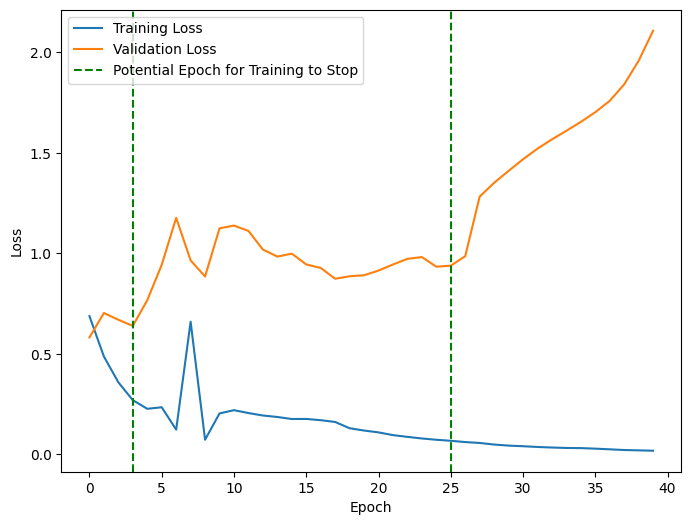

In [92]:
# Plot our train loss and test loss over epochs.
train_loss = history_lstm.history['loss']
test_loss = history_lstm.history['val_loss']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over the 20 epochs.
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')

# Set number of epoch threshold for this model
# Add vertical line with label
plt.axvline(3, linestyle='--', color='green', label='Potential Epoch for Training to Stop')
plt.axvline(25, linestyle='--', color='green')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

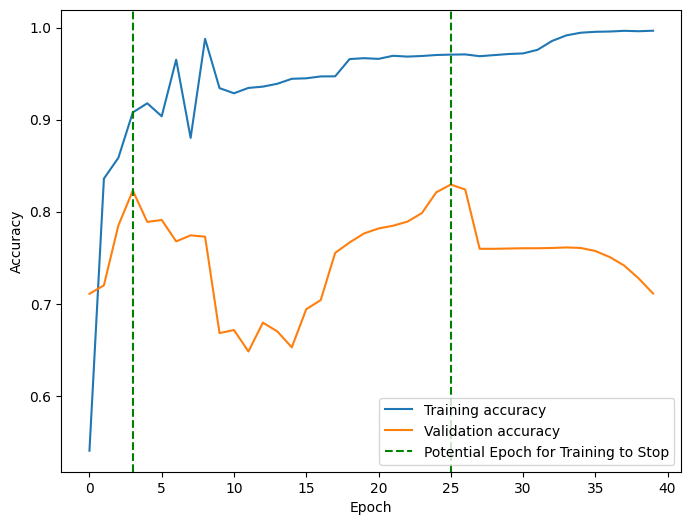

In [93]:
# Set figure size.
plt.figure(figsize=(8, 6))

plt.plot(history_lstm.history['accuracy'], label='Training accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation accuracy')

# Set number of epoch threshold for this model
# Add vertical line with label
plt.axvline(3, linestyle='--', color='green', label='Potential Epoch for Training to Stop')
plt.axvline(25, linestyle='--', color='green')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [94]:
# Get the prediction probability of overstride within each frame
lstm_predictions = lstm_dropout.predict(X_test_scaled)

# Get the max probability across all 258 frames within each video
video_max_probabilities = np.max(lstm_predictions, axis = 1)

threshold = 0.5 # If probability of frame most predicted to have an overstride is above 0.5, classify as overstride

y_pred = (video_max_probabilities > threshold).astype(int) # Convert all labels to binary

# Flatten y_pred into a 1D array
y_pred_flat = np.array(y_pred).flatten()

# Flatten y_test into a 1D array
y_test_flat = np.max(y_test, axis=1)

1/1 [==============================] - 0s 322ms/step


              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       1.00      0.64      0.78        11

    accuracy                           0.69        13
   macro avg       0.67      0.82      0.64        13
weighted avg       0.90      0.69      0.74        13



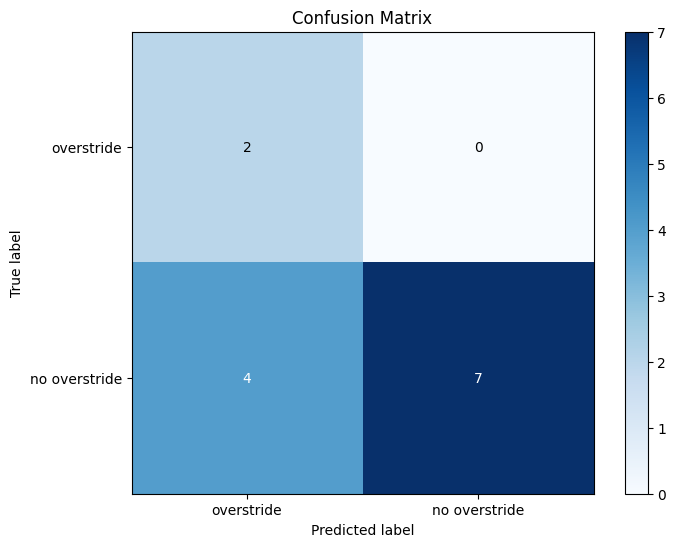

In [95]:
# Generate classification report
report = classification_report(y_pred_flat, y_test_flat)
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_pred_flat, y_test_flat)

# Plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')

# Add annotations to the plot
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names)
plt.yticks(tick_marks, label_names)
plt.show()

At 40 Epochs, Test accuracy was 0.71. However the model is overfit to the training set, after 8 epochs. Next, I will look at training the model up to 3 and 25 epochs to evaluate the accuracy and recall. In this case, I will be visually assessing the recall by looking for the lowest number of false negatives.

### 5.1.3 Fit Model with 3 Epochs

In [97]:
# Before running this, rerun the model architecture to reset the number of epochs trained on this model

# Fitting the model again only with 3 epochs
lstm_dropout.fit(X_train_scaled, y_train,
                 validation_data = (X_val_scaled, y_val),
                 batch_size=64,
                 epochs=3)

Epoch 1/3


1/1 [==============================] - 2s 2s/step - loss: 0.6879 - accuracy: 0.5404 - val_loss: 0.5825 - val_accuracy: 0.7108
Epoch 2/3
1/1 [==============================] - 0s 107ms/step - loss: 0.4871 - accuracy: 0.8359 - val_loss: 0.7036 - val_accuracy: 0.7200
Epoch 3/3
1/1 [==============================] - 0s 107ms/step - loss: 0.3589 - accuracy: 0.8585 - val_loss: 0.6700 - val_accuracy: 0.7850


In [98]:
# Evaluate the model on the test dataset
loss, accuracy = lstm_dropout.evaluate(X_test_scaled, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 [==============================] - 0s 34ms/step - loss: 0.8734 - accuracy: 0.7260
Test Loss: 0.8734045624732971
Test Accuracy: 0.7259988188743591


In [99]:
# Get the prediction probability of overstride within each frame
lstm_predictions = lstm_dropout.predict(X_test_scaled)

# Get the max probability across all 258 frames within each video
video_max_probabilities = np.max(lstm_predictions, axis = 1)

threshold = 0.5 # If probability of frame most predicted to have an overstride is above 0.5, classify as overstride

y_pred = (video_max_probabilities > threshold).astype(int) # Convert all labels to binary

# Flatten y_pred into a 1D array
y_pred_flat = np.array(y_pred).flatten()

# Flatten y_test into a 1D array
y_test_flat = np.max(y_test, axis=1)

1/1 [==============================] - 0s 323ms/step


              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.86      0.67      0.75         9

    accuracy                           0.69        13
   macro avg       0.68      0.71      0.68        13
weighted avg       0.75      0.69      0.70        13



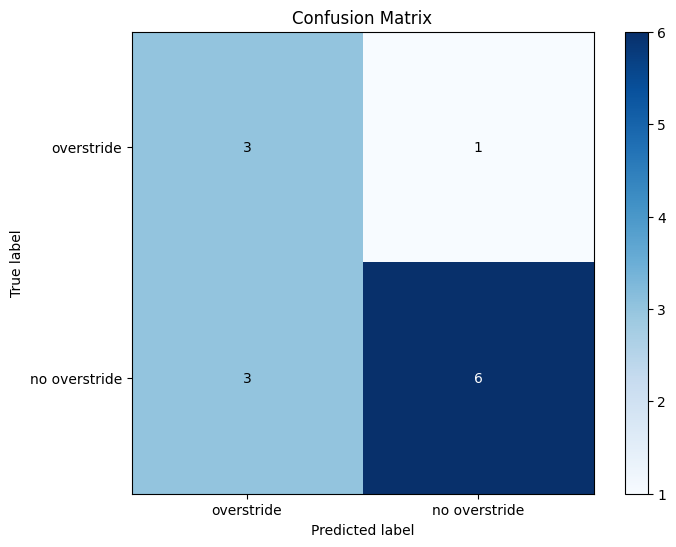

In [100]:
# Generate classification report
report = classification_report(y_pred_flat, y_test_flat)
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_pred_flat, y_test_flat)

# Plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')

# Add annotations to the plot
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names)
plt.yticks(tick_marks, label_names)
plt.show()

### 5.1.4 Fit Model with 25 Epochs

In [103]:
# Before running this, rerun the model architecture to reset the number of epochs trained on this model

# Fitting the model again only with 25 epochs
lstm_dropout.fit(X_train_scaled, y_train,
                 validation_data = (X_val_scaled, y_val),
                 batch_size=64,
                 epochs=25)

Epoch 1/25


1/1 [==============================] - 2s 2s/step - loss: 0.6879 - accuracy: 0.5404 - val_loss: 0.5825 - val_accuracy: 0.7108
Epoch 2/25
1/1 [==============================] - 0s 105ms/step - loss: 0.4871 - accuracy: 0.8359 - val_loss: 0.7036 - val_accuracy: 0.7200
Epoch 3/25
1/1 [==============================] - 0s 107ms/step - loss: 0.3589 - accuracy: 0.8585 - val_loss: 0.6700 - val_accuracy: 0.7850
Epoch 4/25
1/1 [==============================] - 0s 109ms/step - loss: 0.2701 - accuracy: 0.9078 - val_loss: 0.6397 - val_accuracy: 0.8229
Epoch 5/25
1/1 [==============================] - 0s 109ms/step - loss: 0.2272 - accuracy: 0.9177 - val_loss: 0.7676 - val_accuracy: 0.7889
Epoch 6/25
1/1 [==============================] - 0s 110ms/step - loss: 0.2349 - accuracy: 0.9036 - val_loss: 0.9437 - val_accuracy: 0.7910
Epoch 7/25
1/1 [==============================] - 0s 107ms/step - loss: 0.1235 - accuracy: 0.9651 - val_loss: 1.1771 - val_accuracy: 0.7677
Epoch 8/25
1/1 [==================

In [104]:
# Evaluate the model on the test dataset
loss, accuracy = lstm_dropout.evaluate(X_test_scaled, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 [==============================] - 0s 27ms/step - loss: 1.8124 - accuracy: 0.6130
Test Loss: 1.8123682737350464
Test Accuracy: 0.6129993796348572


In [105]:
# Get the prediction probability of overstride within each frame
lstm_predictions = lstm_dropout.predict(X_test_scaled)

# Get the max probability across all 258 frames within each video
video_max_probabilities = np.max(lstm_predictions, axis = 1)

threshold = 0.5 # If probability of frame most predicted to have an overstride is above 0.5, classify as overstride

y_pred = (video_max_probabilities > threshold).astype(int) # Convert all labels to binary

# Flatten y_pred into a 1D array
y_pred_flat = np.array(y_pred).flatten()

# Flatten y_test into a 1D array
y_test_flat = np.max(y_test, axis=1)

1/1 [==============================] - 0s 324ms/step


              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.86      0.60      0.71        10

    accuracy                           0.62        13
   macro avg       0.60      0.63      0.58        13
weighted avg       0.74      0.62      0.65        13



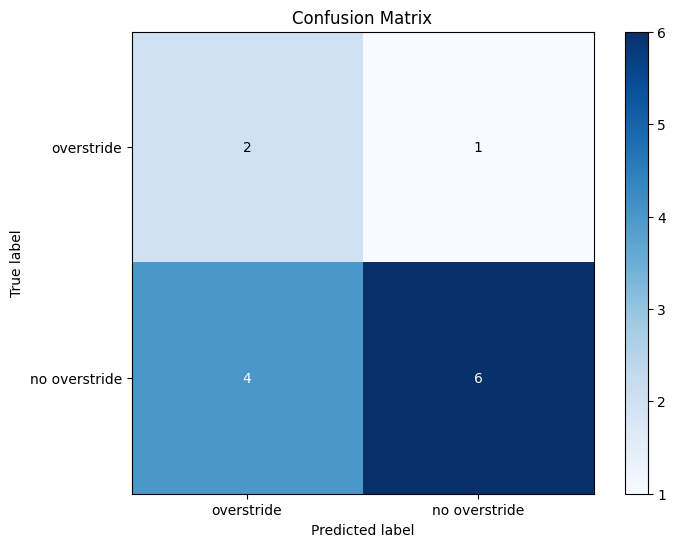

In [106]:
# Generate classification report
report = classification_report(y_pred_flat, y_test_flat)
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_pred_flat, y_test_flat)

# Plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')

# Add annotations to the plot
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names)
plt.yticks(tick_marks, label_names)
plt.show()

## 5.2 CNN + LSTM

### 5.2.1 Model Architecture

In [123]:
# Set random seeds for reproducibility
set_seed()

# Define the learning rate
learning_rate = 0.001  # You can adjust this value as needed

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Initialize the model
cnn_lstm = Sequential()

# Conv1D layer for feature extraction with 'same' padding to preserve sequence length
cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_lstm.add(Dropout(0.4))  # Adding Dropout after Conv1D

# LSTM layer for sequence processing without changing sequence length
cnn_lstm.add(LSTM(units=100, return_sequences=True))
cnn_lstm.add(Dropout(0.4))  # Adding Dropout after LSTM

# Dense layer for classification
cnn_lstm.add(Dense(units=1, activation='sigmoid'))

# Compile the model
cnn_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
cnn_lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 258, 64)           18880     
                                                                 
 dropout_20 (Dropout)        (None, 258, 64)           0         
                                                                 
 lstm_18 (LSTM)              (None, 258, 100)          66000     
                                                                 
 dropout_21 (Dropout)        (None, 258, 100)          0         
                                                                 
 dense_10 (Dense)            (None, 258, 1)            101       
                                                                 
Total params: 84981 (331.96 KB)
Trainable params: 84981 (331.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 5.2.2 Fit Model with 40 Epochs

In [108]:
# Train the model
history_cnn_lstm = cnn_lstm.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    batch_size=32,
                    epochs=40)

Epoch 1/40
2/2 [==============================] - 1s 278ms/step - loss: 0.7804 - accuracy: 0.3711 - val_loss: 0.6558 - val_accuracy: 0.6518
Epoch 2/40
2/2 [==============================] - 0s 64ms/step - loss: 0.6036 - accuracy: 0.7317 - val_loss: 0.5538 - val_accuracy: 0.7451
Epoch 3/40
2/2 [==============================] - 0s 67ms/step - loss: 0.5104 - accuracy: 0.8352 - val_loss: 0.4970 - val_accuracy: 0.8041
Epoch 4/40
2/2 [==============================] - 0s 63ms/step - loss: 0.4522 - accuracy: 0.8363 - val_loss: 0.4821 - val_accuracy: 0.8166
Epoch 5/40
2/2 [==============================] - 0s 63ms/step - loss: 0.4148 - accuracy: 0.8328 - val_loss: 0.5051 - val_accuracy: 0.8032
Epoch 6/40
2/2 [==============================] - 0s 64ms/step - loss: 0.3812 - accuracy: 0.8387 - val_loss: 0.5669 - val_accuracy: 0.7806
Epoch 7/40
2/2 [==============================] - 0s 65ms/step - loss: 0.3527 - accuracy: 0.8538 - val_loss: 0.6403 - val_accuracy: 0.7537
Epoch 8/40
2/2 [==========

In [109]:
# Evaluate the model on the test dataset (40 epochs)
loss, accuracy = cnn_lstm.evaluate(X_test_scaled, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 [==============================] - 0s 33ms/step - loss: 1.4932 - accuracy: 0.7039
Test Loss: 1.4932200908660889
Test Accuracy: 0.7039356231689453


<function matplotlib.pyplot.show(close=None, block=None)>

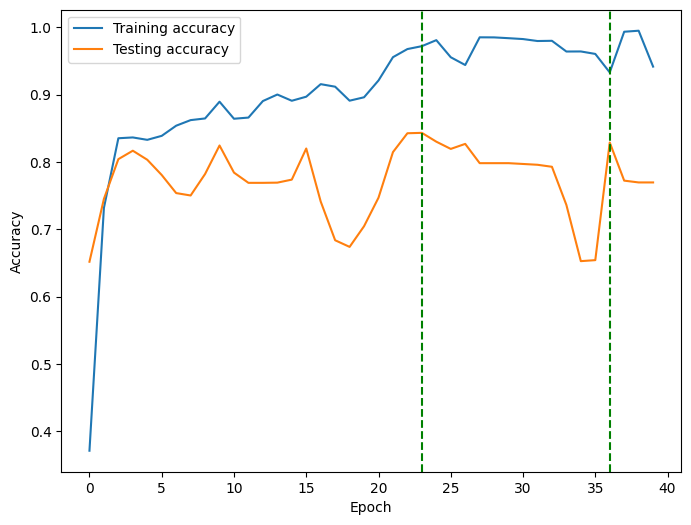

In [111]:
# Set figure size.
plt.figure(figsize=(8, 6))

plt.plot(history_cnn_lstm.history['accuracy'], label='Training accuracy')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Testing accuracy')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

# Set number of epoch threshold for this model
# Add vertical line with label
plt.axvline(36, linestyle='--', color='green', label='Potential Epoch for Training to Stop')
plt.axvline(23, linestyle='--', color='green')

plt.show

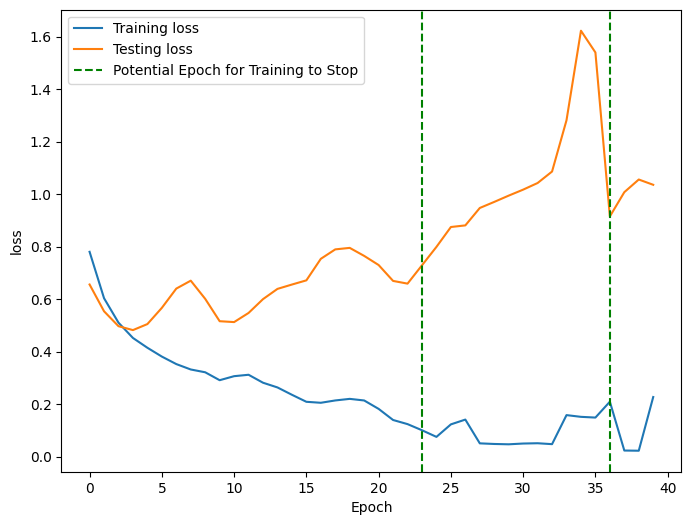

In [113]:
# Set figure size.
plt.figure(figsize=(8, 6))

plt.plot(history_cnn_lstm.history['loss'], label='Training loss')
plt.plot(history_cnn_lstm.history['val_loss'], label='Testing loss')

# Set number of epoch threshold for this model
# Add vertical line with label
plt.axvline(36, linestyle='--', color='green', label='Potential Epoch for Training to Stop')
plt.axvline(23, linestyle='--', color='green')

# Set title
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend();

In [114]:
# Get the prediction probability of overstride within each frame
cnn_lstm_pred = cnn_lstm.predict(X_test_scaled)

# Get the max probability across all 258 frames within each video
video_max_probabilities = np.max(cnn_lstm_pred, axis = 1)

threshold = 0.7 # If probability of frame most predicted to have an overstride is above 0.7 (threshold as observed from below), classify as overstride

y_pred = (video_max_probabilities > threshold).astype(int) # Convert all labels to binary

# Flatten y_pred into a 1D array
y_pred_flat = np.array(y_pred).flatten()

# Flatten y_test into a 1D array
y_test_flat = np.max(y_test, axis=1)

1/1 [==============================] - 0s 200ms/step


              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.86      0.75      0.80         8

    accuracy                           0.77        13
   macro avg       0.76      0.78      0.76        13
weighted avg       0.78      0.77      0.77        13



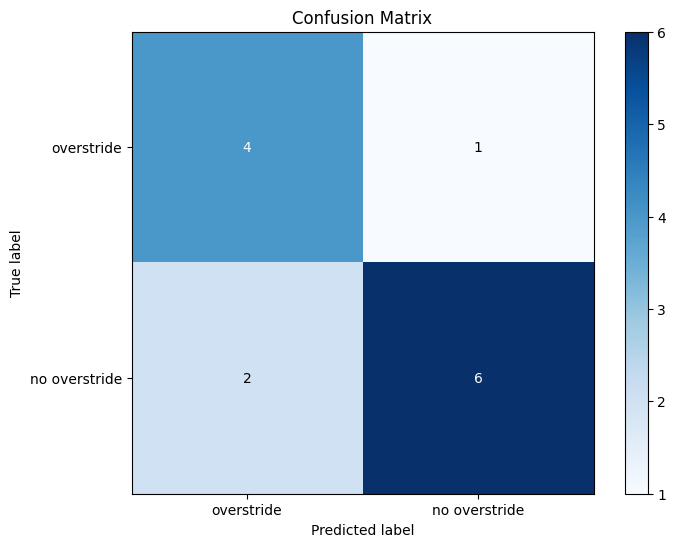

In [115]:
# Generate classification report
report = classification_report(y_pred_flat, y_test_flat)
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_pred_flat, y_test_flat)

# Plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')

# Add annotations to the plot
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names)
plt.yticks(tick_marks, label_names)
plt.show()

### 5.2.3 Fit Model with 23 Epochs

In [117]:
# Before running this, rerun the model architecture to reset the number of epochs trained on this model

# Fit the model with 37 epochs
cnn_lstm.fit(X_train_scaled, y_train,
             validation_data=(X_val_scaled, y_val),
             batch_size=32,
             epochs=23)  # Set epochs to 23 directly

Epoch 1/23
2/2 [==============================] - 1s 275ms/step - loss: 0.7804 - accuracy: 0.3711 - val_loss: 0.6558 - val_accuracy: 0.6518
Epoch 2/23
2/2 [==============================] - 0s 63ms/step - loss: 0.6036 - accuracy: 0.7317 - val_loss: 0.5538 - val_accuracy: 0.7451
Epoch 3/23
2/2 [==============================] - 0s 63ms/step - loss: 0.5104 - accuracy: 0.8352 - val_loss: 0.4970 - val_accuracy: 0.8041
Epoch 4/23
2/2 [==============================] - 0s 63ms/step - loss: 0.4522 - accuracy: 0.8363 - val_loss: 0.4821 - val_accuracy: 0.8166
Epoch 5/23
2/2 [==============================] - 0s 63ms/step - loss: 0.4148 - accuracy: 0.8328 - val_loss: 0.5051 - val_accuracy: 0.8032
Epoch 6/23
2/2 [==============================] - 0s 64ms/step - loss: 0.3812 - accuracy: 0.8387 - val_loss: 0.5669 - val_accuracy: 0.7806
Epoch 7/23
2/2 [==============================] - 0s 63ms/step - loss: 0.3527 - accuracy: 0.8538 - val_loss: 0.6403 - val_accuracy: 0.7537
Epoch 8/23
2/2 [==========

In [118]:
loss, accuracy = cnn_lstm.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 30ms/step - loss: 1.1824 - accuracy: 0.7203


In [119]:
# Get the prediction probability of overstride within each frame
cnn_lstm_pred = cnn_lstm.predict(X_test_scaled)

# Get the max probability across all 258 frames within each video
video_max_probabilities = np.max(cnn_lstm_pred, axis = 1)

threshold = 0.7 # If probability of frame most predicted to have an overstride is above 0.7 (threshold as observed from below), classify as overstride

y_pred = (video_max_probabilities > threshold).astype(int) # Convert all labels to binary

# Flatten y_pred into a 1D array
y_pred_flat = np.array(y_pred).flatten()

# Flatten y_test into a 1D array
y_test_flat = np.max(y_test, axis=1)

1/1 [==============================] - 1s 583ms/step


In [120]:
video_max_probabilities

array([[0.5789599 ],
       [0.9979758 ],
       [0.9979842 ],
       [0.50657314],
       [0.9936538 ],
       [0.9980077 ],
       [0.9972322 ],
       [0.9982651 ],
       [0.99812096],
       [0.62183183],
       [0.44915816],
       [0.9977459 ],
       [0.9352416 ]], dtype=float32)

In [121]:
y_pred_flat

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1])

              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.86      0.67      0.75         9

    accuracy                           0.69        13
   macro avg       0.68      0.71      0.68        13
weighted avg       0.75      0.69      0.70        13



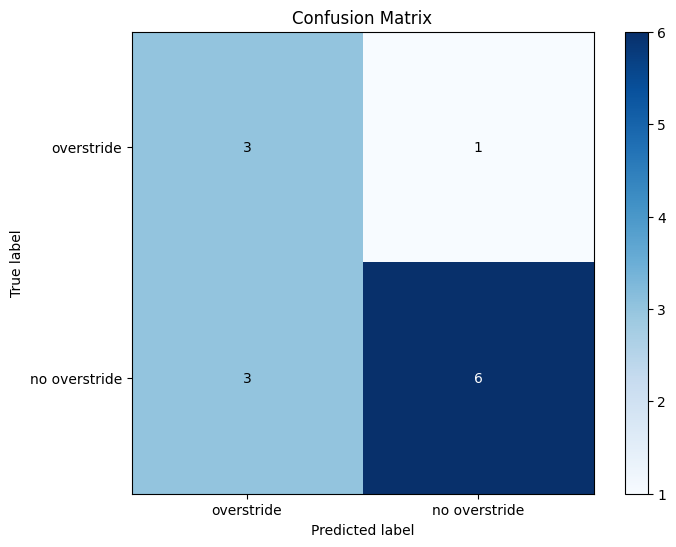

In [122]:
# Generate classification report
report = classification_report(y_pred_flat, y_test_flat)
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_pred_flat, y_test_flat)

# Plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')

# Add annotations to the plot
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names)
plt.yticks(tick_marks, label_names)
plt.show()

### 5.2.4 Fit Model with 36 Epochs

In [124]:
# Before running this, rerun the model architecture to reset the number of epochs trained on this model

# Fit the model with 36 epochs
cnn_lstm.fit(X_train_scaled, y_train,
             validation_data=(X_val_scaled, y_val),
             batch_size=32,
             epochs=36)  # Set epochs to 37 directly

Epoch 1/36
2/2 [==============================] - 1s 274ms/step - loss: 0.7804 - accuracy: 0.3711 - val_loss: 0.6558 - val_accuracy: 0.6518
Epoch 2/36
2/2 [==============================] - 0s 64ms/step - loss: 0.6036 - accuracy: 0.7317 - val_loss: 0.5538 - val_accuracy: 0.7451
Epoch 3/36
2/2 [==============================] - 0s 66ms/step - loss: 0.5104 - accuracy: 0.8352 - val_loss: 0.4970 - val_accuracy: 0.8041
Epoch 4/36
2/2 [==============================] - 0s 63ms/step - loss: 0.4522 - accuracy: 0.8363 - val_loss: 0.4821 - val_accuracy: 0.8166
Epoch 5/36
2/2 [==============================] - 0s 63ms/step - loss: 0.4148 - accuracy: 0.8328 - val_loss: 0.5051 - val_accuracy: 0.8032
Epoch 6/36
2/2 [==============================] - 0s 64ms/step - loss: 0.3812 - accuracy: 0.8387 - val_loss: 0.5669 - val_accuracy: 0.7806
Epoch 7/36
2/2 [==============================] - 0s 63ms/step - loss: 0.3527 - accuracy: 0.8538 - val_loss: 0.6403 - val_accuracy: 0.7537
Epoch 8/36
2/2 [==========

In [126]:
loss, accuracy = cnn_lstm.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 31ms/step - loss: 1.6594 - accuracy: 0.6890


In [127]:
# Get the prediction probability of overstride within each frame
cnn_lstm_pred = cnn_lstm.predict(X_test_scaled)

# Get the max probability across all 258 frames within each video
video_max_probabilities = np.max(cnn_lstm_pred, axis = 1)

threshold = 0.7 # If probability of frame most predicted to have an overstride is above 0.7 (threshold as observed from below), classify as overstride

y_pred = (video_max_probabilities > threshold).astype(int) # Convert all labels to binary

# Flatten y_pred into a 1D array
y_pred_flat = np.array(y_pred).flatten()

# Flatten y_test into a 1D array
y_test_flat = np.max(y_test, axis=1)

1/1 [==============================] - 0s 200ms/step


              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       1.00      0.64      0.78        11

    accuracy                           0.69        13
   macro avg       0.67      0.82      0.64        13
weighted avg       0.90      0.69      0.74        13



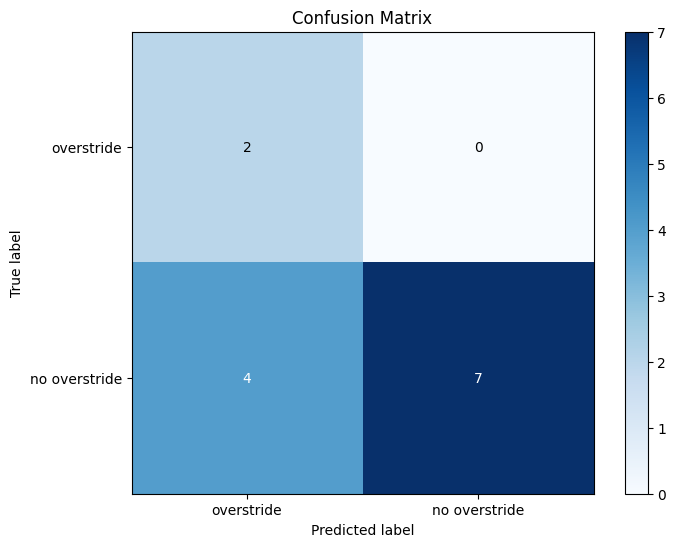

In [128]:
# Generate classification report
report = classification_report(y_pred_flat, y_test_flat)
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_pred_flat, y_test_flat)

# Plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')

# Add annotations to the plot
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names)
plt.yticks(tick_marks, label_names)
plt.show()

In [ ]:
# Save model as h5 file
cnn_lstm.save('../models/cnn_lstm_model.h5')

# Save model as keras file
cnn_lstm.save('../models/cnn_lstm_model.keras')

## 5.3 Layered LSTMs and FNN

In [137]:
# Set random seeds for reproducibility
set_seed()

# Define the learning rate
learning_rate = 0.001  # You can adjust this value as needed

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Initialize the model
lstm_nn = Sequential()

# First LSTM layer
lstm_nn.add(LSTM(32,
               return_sequences=True, 
               activation='tanh',  # Using hyperbolic tangent activation function
               input_shape=(X_train.shape[1], X_train.shape[2])))

# Second LSTM layer
lstm_nn.add(LSTM(64,
               return_sequences=True, 
               activation='tanh'))  # Using hyperbolic tangent activation function

# Third LSTM layer
lstm_nn.add(LSTM(128,
               return_sequences=True, 
               activation='tanh'))  # Using hyperbolic tangent activation function

# Feed Forward Neural Network
lstm_nn.add(Dense(64, activation='relu'))  # Using Rectified Linear Unit (ReLU) activation function

# Feed Forward Neural Network
lstm_nn.add(Dense(32, activation='relu'))  # Using Rectified Linear Unit (ReLU) activation function

# Output layer for classification
lstm_nn.add(Dense(units=1, activation='sigmoid'))  # Using Sigmoid activation function for binary classification

# Compile the model
lstm_nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
lstm_nn.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 258, 32)           16768     
                                                                 
 lstm_26 (LSTM)              (None, 258, 64)           24832     
                                                                 
 lstm_27 (LSTM)              (None, 258, 128)          98816     
                                                                 
 dense_17 (Dense)            (None, 258, 64)           8256      
                                                                 
 dense_18 (Dense)            (None, 258, 32)           2080      
                                                                 
 dense_19 (Dense)            (None, 258, 1)            33        
                                                                 
Total params: 150785 (589.00 KB)
Trainable params: 15

In [138]:
# Train the model
history_lstm_nn = lstm_nn.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    batch_size=32,
                    epochs=40)

Epoch 1/40


2/2 [==============================] - 3s 1s/step - loss: 0.6902 - accuracy: 0.5261 - val_loss: 0.6718 - val_accuracy: 0.6541
Epoch 2/40
2/2 [==============================] - 0s 137ms/step - loss: 0.6492 - accuracy: 0.8159 - val_loss: 0.6447 - val_accuracy: 0.6300
Epoch 3/40
2/2 [==============================] - 0s 140ms/step - loss: 0.6120 - accuracy: 0.8188 - val_loss: 0.6146 - val_accuracy: 0.6989
Epoch 4/40
2/2 [==============================] - 0s 141ms/step - loss: 0.5618 - accuracy: 0.8553 - val_loss: 0.5890 - val_accuracy: 0.6852
Epoch 5/40
2/2 [==============================] - 0s 145ms/step - loss: 0.5050 - accuracy: 0.8415 - val_loss: 0.5852 - val_accuracy: 0.6535
Epoch 6/40
2/2 [==============================] - 0s 139ms/step - loss: 0.4443 - accuracy: 0.8477 - val_loss: 0.6445 - val_accuracy: 0.6482
Epoch 7/40
2/2 [==============================] - 0s 136ms/step - loss: 0.4073 - accuracy: 0.8520 - val_loss: 0.6496 - val_accuracy: 0.6655
Epoch 8/40
2/2 [==================

In [139]:
loss, accuracy = lstm_nn.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 51ms/step - loss: 2.2272 - accuracy: 0.6750


In [140]:
# Get the prediction probability of overstride within each frame
lstm_nn_pred = lstm_nn.predict(X_test_scaled)

# Get the max probability across all 258 frames within each video
video_max_probabilities = np.max(lstm_nn_pred, axis = 1)

threshold = 0.7 # If probability of frame most predicted to have an overstride is above 0.7 (threshold as observed from below), classify as overstride

y_pred = (video_max_probabilities > threshold).astype(int) # Convert all labels to binary

# Flatten y_pred into a 1D array
y_pred_flat = np.array(y_pred).flatten()

# Flatten y_test into a 1D array
y_test_flat = np.max(y_test, axis=1)

1/1 [==============================] - 1s 520ms/step


              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.86      0.67      0.75         9

    accuracy                           0.69        13
   macro avg       0.68      0.71      0.68        13
weighted avg       0.75      0.69      0.70        13



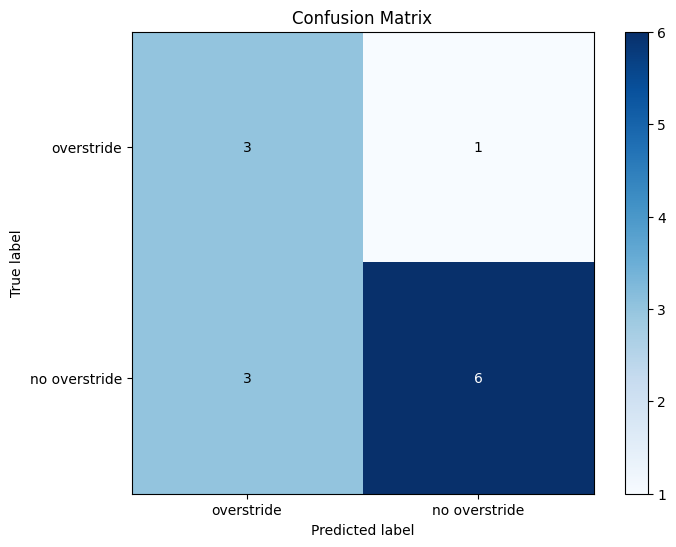

In [141]:
# Generate classification report
report = classification_report(y_pred_flat, y_test_flat)
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_pred_flat, y_test_flat)

# Plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')

# Add annotations to the plot
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names)
plt.yticks(tick_marks, label_names)
plt.show()

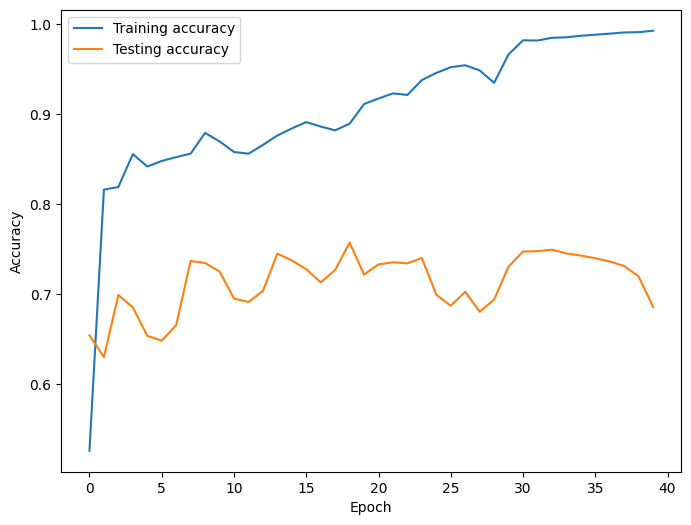

In [145]:
# Set figure size.
plt.figure(figsize=(8, 6))

plt.plot(history_lstm_nn.history['accuracy'], label='Training accuracy')
plt.plot(history_lstm_nn.history['val_accuracy'], label='Testing accuracy')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

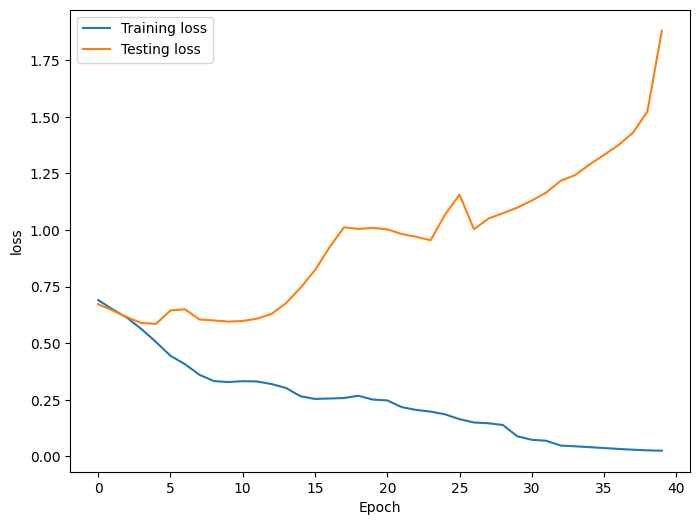

In [144]:
# Set figure size.
plt.figure(figsize=(8, 6))

plt.plot(history_lstm_nn.history['loss'], label='Training loss')
plt.plot(history_lstm_nn.history['val_loss'], label='Testing loss')

# Set title
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend();

# 6. Model Evaluation

**Conclusion:**<br>

Three models of varying compplexities and types of neural network layers were attempted. Below is a table summary of all the models ran and an evaluation of each:

1. LSTM > LSTM > TimeDistributed(Dense)

|No. of epochs|40|6|11|
|---|---|---|---|
|Accuracy|0.75|0.72|0.63|
|Recall|0.80|0.75|1.0|

2. Conv1D > LSTM > Dense

|No. of epochs|40|23|37|
|---|---|---|---|
|Accuracy|0.77|0.71|0.75|
|Recall|0.75|0.75|1.0|

3. LSTM > LSTM > LSTM > Dense > Dense > Dense

|No. of epochs|40|
|---|---|
|Accuracy|0.46|
|Recall|0.46|

<span style="color:red">NOTE:</span>
The results stated above are from the previous rounds of training, I am now updating the model parameters to get better results thus there will be a difference in the results stated in conclusion and the results from the models above.

<br>
Next steps for model accuracy improvement:
- Use keras tuner for gridsearch
- Look more in depth into pre-trained models for pose estimation data